In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [2]:
import FinanceDataReader as fdr

In [5]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2023-01-01', '2024-12-31')
df.tail

<bound method NDFrame.tail of              Open   High    Low  Close    Volume    Change
Date                                                      
2023-01-02  55500  56100  55200  55500  10031448  0.003617
2023-01-03  55400  56000  54500  55400  13547030 -0.001802
2023-01-04  55700  58000  55600  57800  20188071  0.043321
2023-01-05  58200  58800  57600  58200  15682826  0.006920
2023-01-06  58300  59400  57900  59000  17334989  0.013746
...           ...    ...    ...    ...       ...       ...
2024-01-17  73100  73300  71000  71000  22683660 -0.022039
2024-01-18  71600  72000  70700  71700  17853397  0.009859
2024-01-19  73500  74700  73000  74700  23363427  0.041841
2024-01-22  75900  76000  75000  75100  19673375  0.005355
2024-01-23  75700  75800  74300  75200  14722676  0.001332

[261 rows x 6 columns]>

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

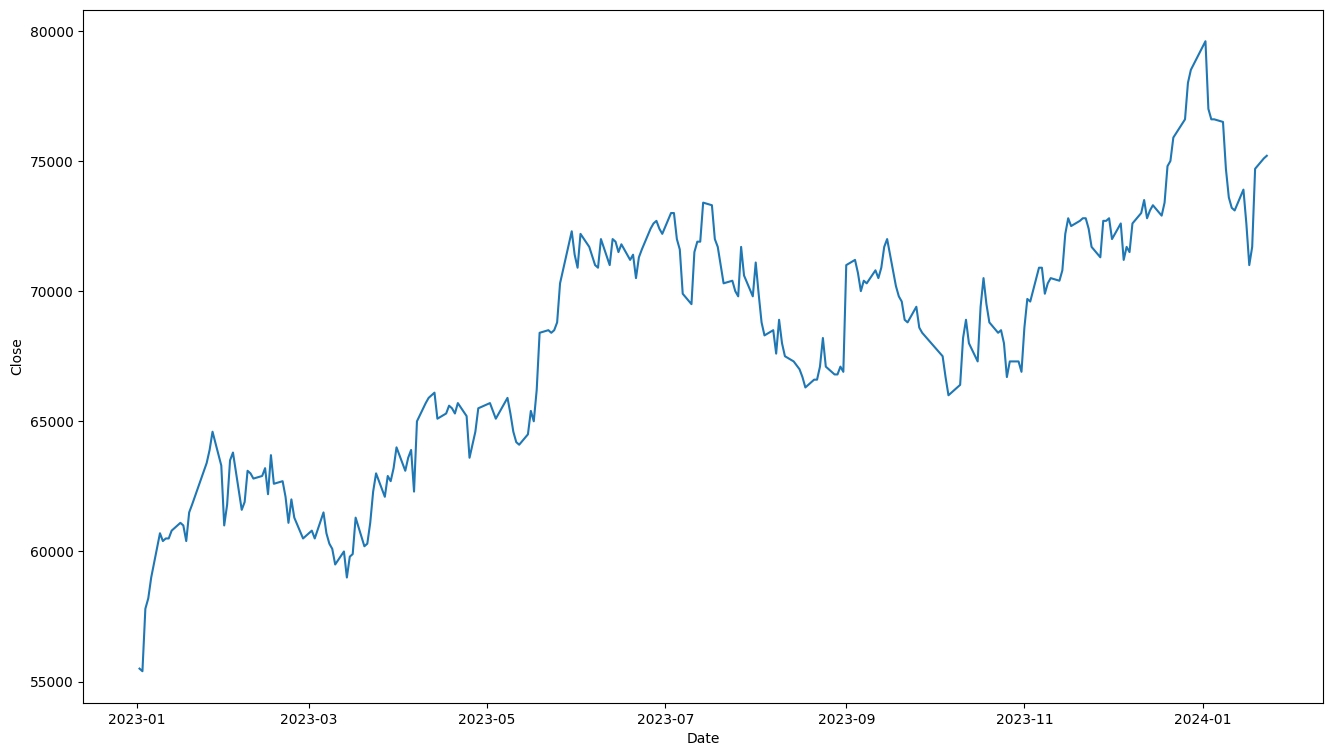

In [7]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [24]:
df # 261일간의 데이터

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-01-02,0.004329,0.004202,0.029536,0.004132,0.081108,0.003617
2023-01-03,0.000000,0.000000,0.000000,0.000000,0.148890,-0.001802
2023-01-04,0.012987,0.084034,0.046414,0.099174,0.276930,0.043321
2023-01-05,0.121212,0.117647,0.130802,0.115702,0.190068,0.006920
2023-01-06,0.125541,0.142857,0.143460,0.148760,0.221922,0.013746
...,...,...,...,...,...,...
2024-01-17,0.766234,0.726891,0.696203,0.644628,0.325046,-0.022039
2024-01-18,0.701299,0.672269,0.683544,0.673554,0.231917,0.009859
2024-01-19,0.783550,0.785714,0.780591,0.797521,0.338152,0.041841


In [8]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [26]:
x[0 : 5].shape

(5, 4)

In [36]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

print(x.shape, y.shape)

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length]) # i = 0이면, 0 ~ 4까지가 x_seq
    y_seq.append(y[i + sequence_length]) # i = 0이면, 5가 y_seq -> 0 ~ 4일 데이터로 5일 데이터를 예측하는 셈
    if i == 0:
        print("한 데이터의 shape:",x[ i : i + sequence_length].shape, y[i + sequence_length].shape)
  print("seq의 shape:",torch.FloatTensor(x_seq).shape, torch.FloatTensor(y_seq).shape)
  print("return shape:",torch.FloatTensor(x_seq).shape, torch.FloatTensor(y_seq).view(-1,1).shape)
  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

(261, 4) (261,)


In [37]:
split = 70 # 70일치가 트레인
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size()) # 70개 트레인
print(x_test_seq.size(), y_test_seq.size()) # 186개 테스트

한 데이터의 shape: (5, 4) ()
seq의 shape: torch.Size([256, 5, 4]) torch.Size([256])
return shape: torch.Size([256, 5, 4]) torch.Size([256, 1])
torch.Size([70, 5, 4]) torch.Size([70, 1])
torch.Size([186, 5, 4]) torch.Size([186, 1])


In [39]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

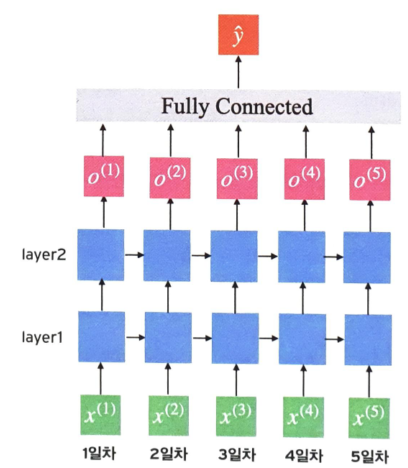

In [13]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2) # 4
num_layers = 2
hidden_size = 8

In [42]:
x_seq.size()

torch.Size([256, 5, 4])

In [52]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x): # input으로는 (batch, 시퀀스 길이 5, 피쳐 4)가 올 것
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정 -> 초기 은닉상태
    out,_ = self.rnn(x, h0) # RNN의 Input으로는 현재의 x와 h(초기 은닉상태)가 들어감. 그리고 Output으로는  (batch, 시퀀스 길이 5, hidden_size 8)이 나옴. _는 마지막 은닉상태인데, 필요 없음.
    out = out.reshape(out.shape[0], -1) # (batch, 나머지차원) 으로 뒤를 펴버림.
    out = self.fc(out) # 나머지차원(hidden_size * sequence_length)을 1로 fc 하여 최종적인 예측값 하나가 나옴. 물론 배치가 5니까 5개의 값이 묶여서 나오겠지.
    return out

In [53]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [54]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [55]:
print(next(iter(train_loader))[0].shape) # 배치사이즈 5, 학습 시퀀스 5, 피쳐 4
print(next(iter(train_loader))[1].shape) # 배치사이즈 5, 정답 1

torch.Size([5, 5, 4])
torch.Size([5, 1])


In [56]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터 seq: (5,5,4), target: (5,1)
    out = model(seq) #출력값 계산 out: (5,1)
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0275
[epoch : 10] loss: 0.0055
[epoch : 20] loss: 0.0053
[epoch : 30] loss: 0.0045
[epoch : 40] loss: 0.0031


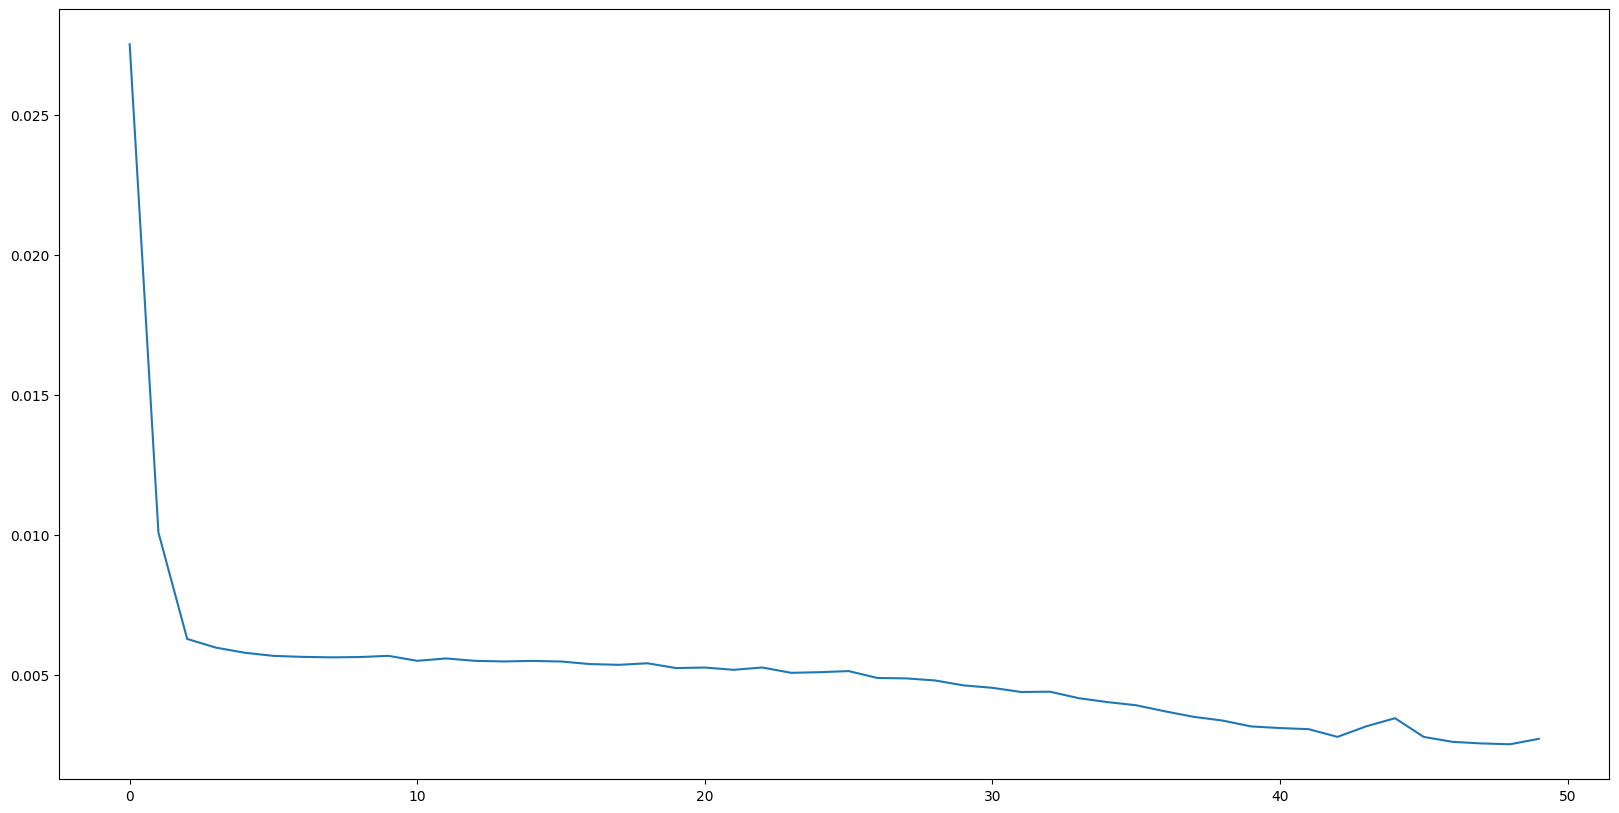

In [57]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [58]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

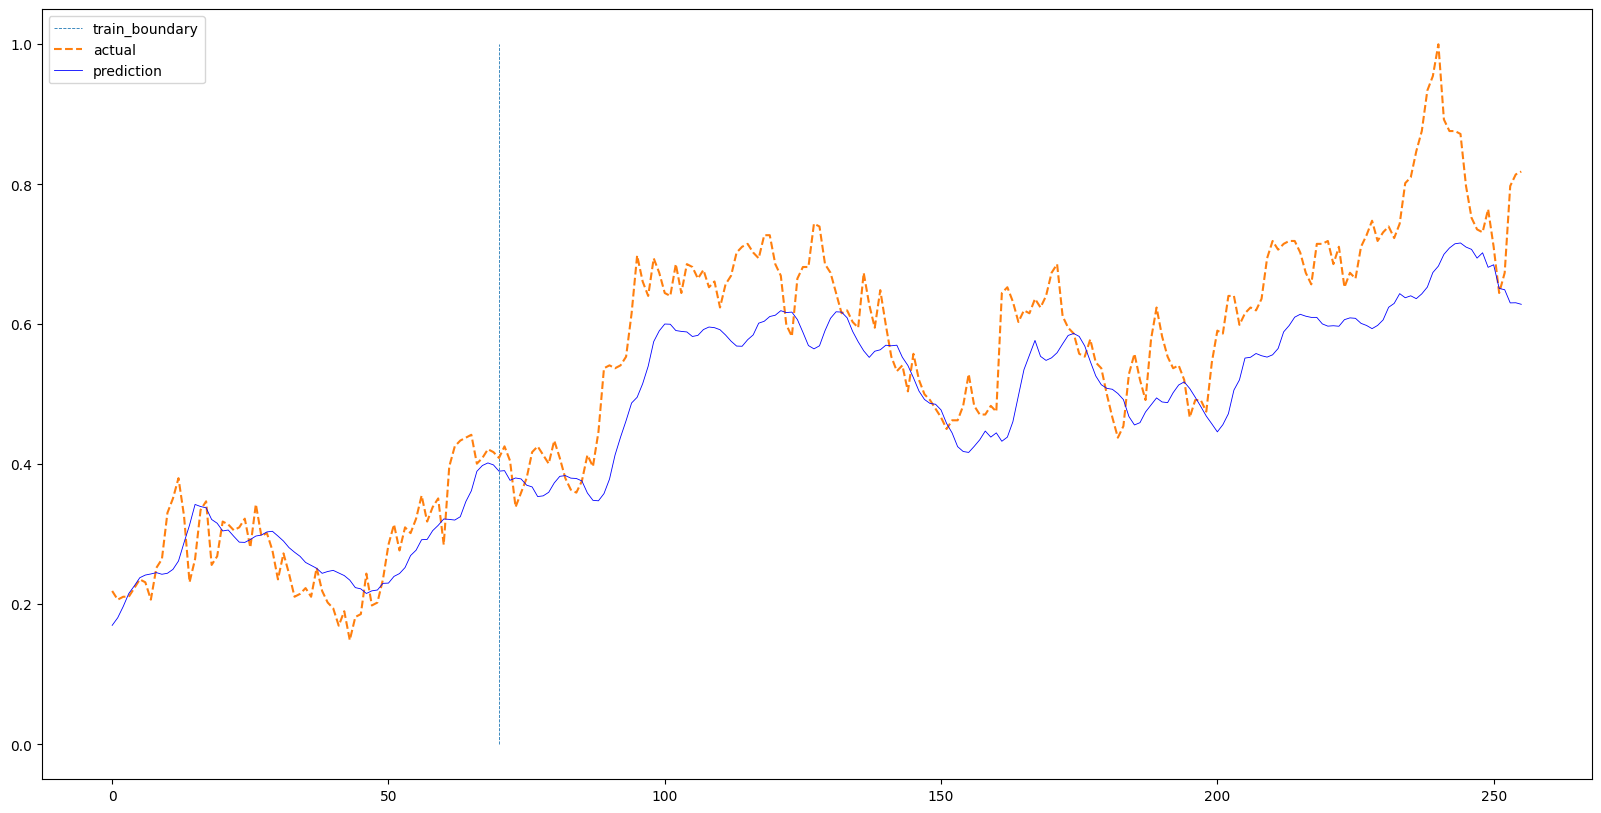

In [59]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [60]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [62]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x): # input으로는 (batch, 시퀀스 길이 5, 피쳐 4)가 올 것
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 은닉 상태
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 셀 상태 -> lstm에서는 이 두 가지가 다음 셀로 전달됨
    out, _ = self.lstm(x,(h0,c0)) # out은 (N, L, D * H_{out}), _는 (h_t) from the last layer of the LSTM
    out = out.reshape(out.shape[0], -1) # 배치 유지하고 뒤에 몰아서 구겨버림
    out = self.fc(out) # 그걸 fc 통과해 하나의 값 뱉음. 물론 배치가 5니까 5개일 것
    return out

- nn.LSTM의 구현 자체가 아래 input을 받도록 되어 있음. 그래서 위 h0, c0를 저렇게 정의해 준 것.
    - D는 LSTM이 양방향(bidirectional)인 경우 2, 단방향인 경우 1
    - num_layers: LSTM 네트워크의 레이어 수
    - N: 배치 크기
    - H_out: 은닉 상태의 크기

**h_0**: tensor of shape (D * \text{num\_layers}, H_{out}) for unbatched input or
(D * \text{num\_layers}, N, H_{out}) containing the
initial hidden state for each element in the input sequence.
Defaults to zeros if (h_0, c_0) is not provided.

**c_0**: tensor of shape (D * \text{num\_layers}, H_{cell}) for unbatched input or
(D * \text{num\_layers}, N, H_{cell}) containing the
initial cell state for each element in the input sequence.
Defaults to zeros if (h_0, c_0) is not provided.

In [63]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [64]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [65]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0141
[epoch: 10] loss: 0.0049
[epoch: 20] loss: 0.0026
[epoch: 30] loss: 0.0025
[epoch: 40] loss: 0.0025


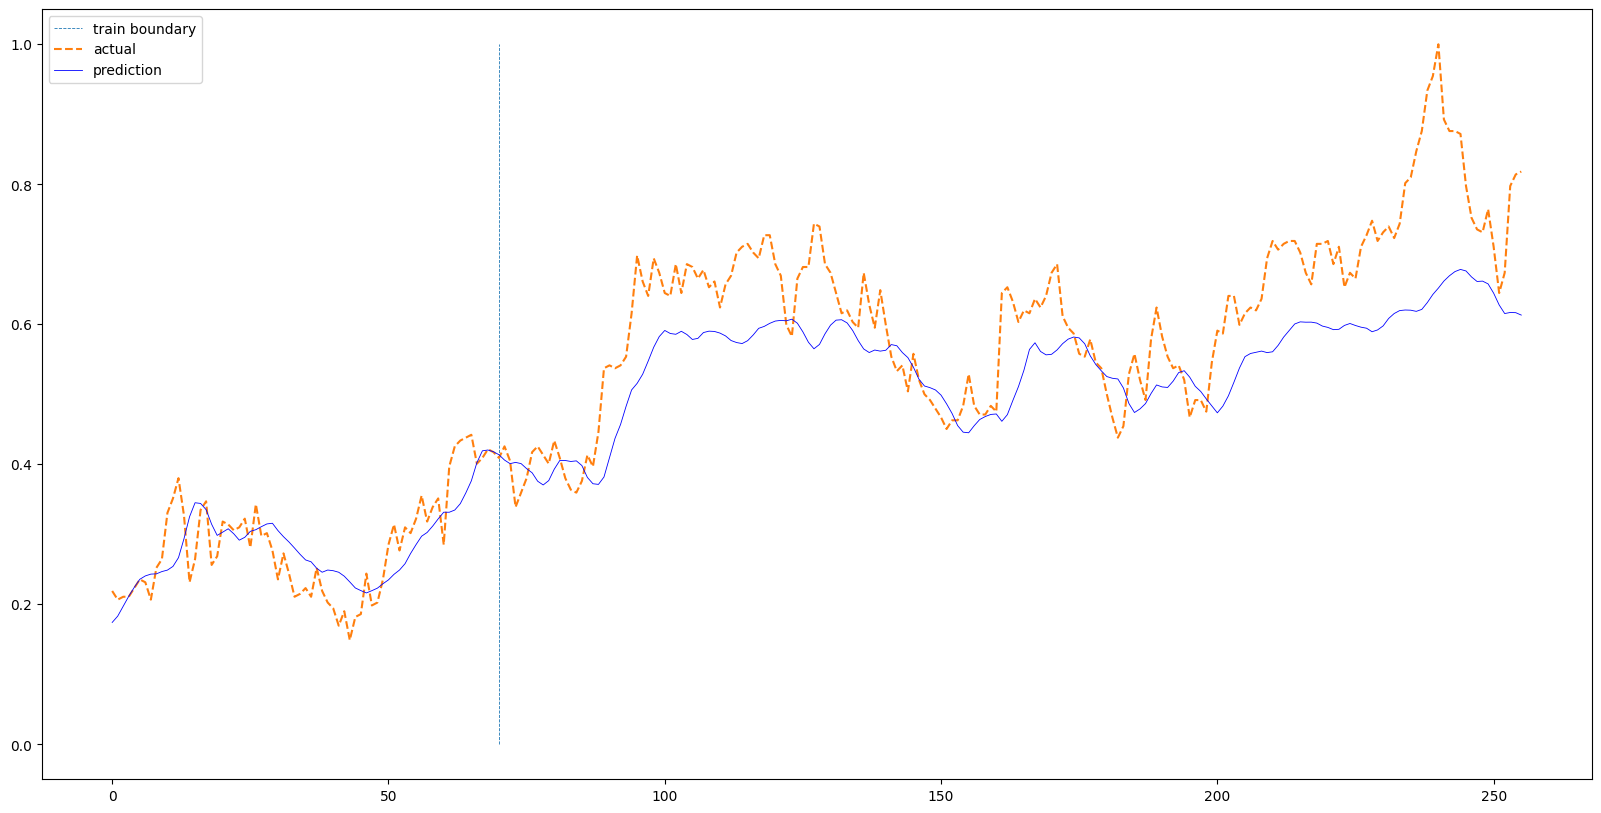

In [66]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()